In [1]:
import pandas as pd

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re

import matplotlib.pyplot as plt

The following preprocessing was done by considering all the json files, although the final test was performed only on the test set.

In [2]:
# train_df = pd.read_json("dataset/train.json", encoding="utf-8", lines=True)
# validation_df = pd.read_json("dataset/validation.json", encoding="utf-8", lines=True)
test_df = pd.read_json("dataset/test.json", encoding="utf-8", lines=True)

len(test_df)

188

In [3]:
def preprocess_text(text):
    text = text.lower()
    
    tokens = word_tokenize(text, language='english')
    
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    preprocessed_text = ' '.join(lemmatized_tokens)
    
    return preprocessed_text

The following procedure is built to:
- Find the frequent patterns that frame the main content of the text (preamble and sign/annex);
- Take the resulting text and apply the preprocessing phase;

For the texts that does not follow the previous rules, we just mark them as None.

In [4]:
patterns = [
    r"HAS ADOPTED THIS REGULATION:",
    r"HAVE ADOPTED THIS REGULATION:",
    r"HAS ADOPTED THESE RULES OF PROCEDURE:",
    r"HEREBY ADOPT THIS RESOLUTION:",
    r"HAVE ADOPTED THIS DIRECTIVE:",
    r"HAD ADOPTED THIS DIRECTIVE:",
    r"The Parties have agreed as follows:",
    r"HAVE ADOPTED THIS DECISION:",
    r"HAS ADOPTED THIS DECISION:",
    r"HAVE AGREED ON THE FOLLOWING PROVISIONS:",
    r"RECOMMENDS THAT MEMBER STATES:",
    r"RECOMMEND THAT MEMBER STATES:",
    r"HAS ADOPTED THIS JOINT ACTION:",
    r"HAS ADOPTED THIS DIRECTIVE:",
    r"HAS ADOPTED THIS DIRECTIVE",
    r"HAVE ADOPTED THIS DIRECTIVE;",
    r"HAS ADOPTED THIS COMMON POSITION:",
    r"HAS ADOPTED THESE RULES:",
    r"HAS ADOPTED THIS RECOMMENDATION:",
    r"HAS ADOPTED THIS RECOMMMENDATION:",
    r"HAVE AGREED AS FOLLOWS:",
    r"HAVE AGREED as follows:",
    r"HAVE DECIDED to conclude the following Convention:",
    r"AGREE AS FOLLOWS:",
    r"HAVE DECIDED TO CREATE A TRANSPORT COMMUNITY:",
    r"HAVE DECIDED TO CONCLUDE THIS AGREEMENT:",
    r"HAVE DECIDED AS FOLLOWS:",
    r"HAS DECIDED AS FOLLOWS:",
    r"HEREBY RECOMMENDS MEMBER STATES:",
    r"HEREBY RECOMMENDS THAT THE MEMBER STATES:",
    r"HEREBY RECOMMENDS THAT THE MEMBER STATES SHOULD:",
    r"HEREBY RECOMMENDS:",
    r"HEREBY RECOMMENDS AS FOLLOWS:",
    r"HEREBY AGREE:",
    r"HEREBY RECOMMENDS THAT MEMBER STATES SHOULD:",
    r"HAVE AGREED THE FOLLOWING:",
    r"The following intergovernmental organizations were represented at the session:",
    r"HAS ADOPTED THIS FRAMEWORK DECISION:",
    r"HAS ADOPTED THIS GUIDELINE:",
    r"DECIDES:"
]

def article_finder(text):
    starting_index = -1
    for pattern in patterns:
        match = re.search(pattern, text)
        if match:
            starting_index = match.start()
        
    if starting_index == -1:
        return None 

    text_without_the_preamble = text[starting_index:]
    ending_index = text_without_the_preamble.rfind(r"Done at")
    if ending_index == -1:
        ending_index = text_without_the_preamble.rfind(r"Adopted in")    
        if ending_index == -1:
            ending_index = text_without_the_preamble.rfind(r"ANNEX") 
            if ending_index == -1:
                ending_index = text_without_the_preamble.rfind(r"IN WITNESS WHEREOF") 
                if ending_index == -1:
                    return preprocess_text(text_without_the_preamble)
    text_without_the_sign = text_without_the_preamble[:ending_index]

    return preprocess_text(text_without_the_sign)

In [5]:
new_columns = ['reference_tokens', 'summary_tokens']

for column in new_columns:
    # train_df[colonna] = 0
    # validation_df[colonna] = 0
    test_df[column] = 0

# This information will be usefull as stopping criterion for the reading algorithms

In [6]:
test_df

,celex_id,reference,summary,reference_tokens,summary_tokens
0,32019R1156,12.7.2019\nEN\nOfficial Journal of the Europea...,Cross-border distribution of collective invest...,0,0
1,32019R1020,25.6.2019\nEN\nOfficial Journal of the Europea...,Market surveillance and compliance of products...,0,0
2,32019L0789,17.5.2019\nEN\nOfficial Journal of the Europea...,Copyright — broadcasters’ online transmissions...,0,0
3,32019R0515,29.3.2019\nEN\nOfficial Journal of the Europea...,Mutual recognition of goods\nMutual recognitio...,0,0
4,32019R0517,29.3.2019\nEN\nOfficial Journal of the Europea...,The .eu top-level domain\nThe .eu top-level do...,0,0
...,...,...,...,...,...
183,32008R0762,13.8.2008\nEN\nOfficial Journal of the Europea...,Aquaculture statistics\nAquaculture statistics...,0,0
184,32010R1236,31.12.2010\nEN\nOfficial Journal of the Europe...,Future international cooperation in north-east...,0,0
185,32010R0066,30.1.2010\nEN\nOfficial Journal of the Europea...,Ecolabel\nEcolabel\nSUMMARY OF:\nRegulation (E...,0,0
186,32009R0469,16.6.2009\nEN\nOfficial Journal of the Europea...,Supplementary protection certificates for medi...,0,0


In [7]:
# for index, row in train_df.iterrows():
#    train_df.loc[index, "reference"] = article_finder(train_df.loc[index, "reference"])
#    if train_df.loc[index, "reference"] is not None:
#        train_df.loc[index, "reference_tokens"] = len(word_tokenize(train_df.loc[index, "reference"], language='english'))
#    train_df.loc[index, "summary_tokens"] = len(word_tokenize(train_df.loc[index, "summary"], language='english'))
    
# for index, _ in train_df.iterrows():
#    if _["reference"] is None:
#        train_df = train_df.drop(index, axis=0)

# for index, row in validation_df.iterrows():
#    validation_df.loc[index, "reference"] = article_finder(validation_df.loc[index, "reference"])
#    if validation_df.loc[index, "reference"] is not None:
#        validation_df.loc[index, "reference_tokens"] = len(word_tokenize(validation_df.loc[index, "reference"], language='english'))
#    validation_df.loc[index, "summary_tokens"] = len(word_tokenize(validation_df.loc[index, "summary"], language='english'))
    
# for index, _ in validation_df.iterrows():
#    if _["reference"] is None:
#        validation_df = validation_df.drop(index, axis=0)

for index, row in test_df.iterrows():
    test_df.loc[index, "reference"] = article_finder(test_df.loc[index, "reference"])
    if test_df.loc[index, "reference"] is not None:
        test_df.loc[index, "reference_tokens"] = len(word_tokenize(test_df.loc[index, "reference"], language='english'))
    test_df.loc[index, "summary_tokens"] = len(word_tokenize(test_df.loc[index, "summary"], language='english'))
    
for index, _ in test_df.iterrows():
    if _["reference"] is None:
        test_df = test_df.drop(index, axis=0)

len(test_df)

187

In [8]:
# train_df.to_csv('dataset/train_processed.csv', index=False)
# validation_df.to_csv('dataset/validation_processed.csv', index=False)
test_df.to_csv('dataset/test_processed.csv', index=False)

The following plots were meant for fine-tuning purposes (in order to set the appropriate max_tokens in the tokenizer):

In [9]:
new_test_df = pd.read_csv("dataset/test_processed.csv")

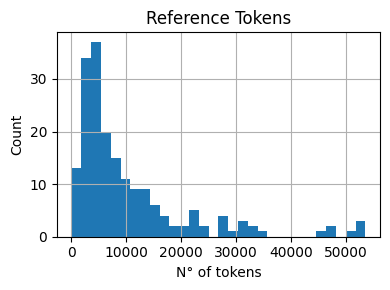

count      187.000000
mean     10355.090909
std      10941.703042
min        100.000000
25%       3670.000000
50%       5760.000000
75%      12639.500000
max      53521.000000
Name: reference_tokens, dtype: float64

In [10]:
reference_tokens = new_test_df["reference_tokens"]

plt.figure(figsize=(4, 3))
plt.hist(reference_tokens, label="Reference Tokens", bins=30)
plt.title("Reference Tokens")
plt.ylabel("Count")
plt.xlabel("N° of tokens")
plt.grid(True)
plt.tight_layout()
plt.savefig("reftokens.jpg")
plt.show()

new_test_df["reference_tokens"].describe()

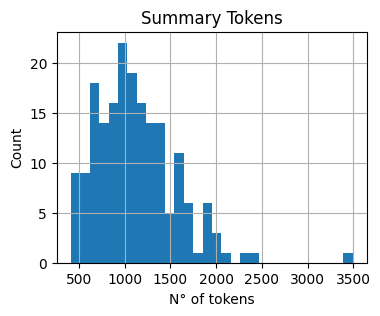

count     187.000000
mean     1119.540107
std       439.898623
min       414.000000
25%       806.000000
50%      1054.000000
75%      1375.000000
max      3493.000000
Name: summary_tokens, dtype: float64

In [11]:
summary_tokens = new_test_df["summary_tokens"]

plt.figure(figsize=(4, 3))
plt.hist(summary_tokens, label="Summary Tokens", bins=30)
plt.title("Summary Tokens")
plt.ylabel("Count")
plt.xlabel("N° of tokens")
plt.grid(True)
plt.show()

new_test_df["summary_tokens"].describe()

In [12]:
# Some examples of the preprocessing

for index, _ in new_test_df[:3].iterrows():
    print(_["reference"][:1000], _["celex_id"])
    print("---------")

have adopted this regulation : article 1 subject matter this regulation establishes uniform rule on the publication of national provision concerning marketing requirement for collective investment undertaking and on marketing communication addressed to investor , a well a common principle concerning fee and charge levied on manager of collective investment undertaking in relation to their cross-border activity . it also provides for the establishment of a central database on the cross-border marketing of collective investment undertaking . article 2 scope this regulation shall apply to : ( a ) alternative investment fund manager ; ( b ) ucits management company , including any ucits which ha not designated a ucits management company ; ( c ) euveca manager ; and ( d ) eusef manager . article 3 definition for the purpose of this regulation , the following definition apply : ( a ) ‘ alternative investment fund ’ or ‘ aifs ’ mean aifs a defined in point ( a ) of article 4 ( 1 ) of directiv